# Kræsjkurs i AI - Grunnleggende prinsipper

- Maskinlæring er så mangt
- Vis litt at det ikke bare er nevrale nettverk.
- Hva betyr "dyp"

Hvorfor går kodebiten bare gjennom Dyp læring?
- Flesteparten av modellene som imponerer oss idag er dype nevrale nettverk
    - ChatGPT
    - GPT-4
    - Stable Diffusion
    - Midjourney
    - AlphaZero
    - 

# Den tekniske biten - Hvordan ser det ut å jobbe med nevrale nettverk nå til dags?
Denne er ment for å gi et kjapt overblikk av hvordan kode ser ut når man jobber med maskinlæring / dyp læring.

## Vektorer
I dyp læring er all data i form av vektorer, matriser og tensorer. Min faglige erfaring tilsier at disse begrepene er generelle og beskriver bare en samling verdier. Rent praktisk er det flerdimensjonale lister/arrays.

In [37]:
import numpy as np

In [38]:
# En vektor med 

## Dimensjoner og _shapes_
Fra matematikken vet vi at en liste med feks. 3 tall definerer en vektor/punkt som lever i et tre-dimensjonalt rom.  

## Rammeverket PyTorch

PyTorch er et av flere biblioteker som brukes til trening av dype nevrale nettverk. Det andre kjente alternativet er TensorFlow. Hva man velger avhenger mye av smak, men begge har sine fordeler og ulemper. Jeg liker PyTorch fordi mindre av treningsprosessen blir gjemt og man har mer frihet.
PyTorch omfatter mye av den funksjonaliteten man finner i Numpy, men tilbyr metoder for trening og konstruksjon av nevrale nettverk. En `np.ndarray` er ekvivalent med en `torch.Tensor`.

In [39]:
import torch

In [40]:
tensor = torch.randn(2, 2)
print(tensor)
print(f"Default tensor location: {tensor.device}")

tensor([[ 0.0566,  0.2066],
        [-0.0996, -0.4264]])
Default tensor location: cpu


In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [42]:
tensor.to(device)

tensor([[ 0.0566,  0.2066],
        [-0.0996, -0.4264]], device='cuda:0')

## Oppsett av nevrale nettverk med PyTorch
Et nevralt nettverk har vanligvis en kompleks struktur. Likevel består de av flere isolerte komponenter, og disse finner man i `torch.nn`. 

De fleste komponentene blir et såkalt _lag_ i nettverket, mens andre komponenter anvendes på eksisterende lag (feks aktiveringsfunksjoner). 

Den enkleste er `torch.nn.Linear`, og setter opp et lineært lag. Matematisk gjør den en lineær transformasjon fra et vektorrom til et annet. Feks kan den ta inn en vektor med 5 elementer, og outputte en vektor med 3 elementer:

<img src="nn_5in_3out-cropped.svg" width="500px" height="auto" alt="SVG Image"  style="filter: invert(100%); "/>




In [43]:
import torch.nn as nn
layer = nn.Linear(in_features=5, out_features=3) # Construct layer
layer

Linear(in_features=5, out_features=3, bias=True)

In [44]:
data = torch.Tensor([[1, 2, 3, 4, 5]])
print(f"Input vector: {data}")
output = layer(data) # Feed data into layer
print(f"Output vector: {output}")

Input vector: tensor([[1., 2., 3., 4., 5.]])
Output vector: tensor([[-1.9570,  0.8826,  3.1182]], grad_fn=<AddmmBackward0>)


In [45]:
print(f"Weights:\n{layer.weight.data}")
print(f"Weight shape: {layer.weight.shape}\n")

print(f"Bias:\n{layer.bias.data}")
print(f"Bias shape: {layer.bias.shape}")

Weights:
tensor([[ 0.1274, -0.2142,  0.0663, -0.0902, -0.2161],
        [ 0.4105,  0.3565, -0.0114,  0.3308, -0.3414],
        [ 0.3387,  0.1754,  0.3943, -0.0491,  0.2512]])
Weight shape: torch.Size([3, 5])

Bias:
tensor([-0.4134,  0.1770,  0.1859])
Bias shape: torch.Size([3])


Når man sender input-vektoren inn skjer følgende operasjon (hvor `@` er matrisemultiplikasjon):

In [46]:
data @ layer.weight.T + layer.bias

tensor([[-1.9570,  0.8826,  3.1182]], grad_fn=<AddBackward0>)

Vi ser fra resultatet over at det stemmer .


Vektene og biaset utgjør til sammen **parametrene**, og er verdiene som endres under trening. Hvordan disse er strukturert og brukes varierer. Konvolusjonelle lag bruker en "sliding window"-mekanisme hvor de samme vektene multipliseres med forskjellige deler av et bilde. Til denne introduksjon holder vi oss derimot til lineære lag. 

### Aktiveringsfunksjoner

Det lineære laget utfører en lineær operasjon. Fleksibiliteten av nevrale nettverk kommer derimot av såkalte _aktiveringsfunksjoner_ som utfører ikke-lineære operasjoner på data. Disse inneholder **vanligvis ikke** trenbare parametre. De enkleste opererer på hvert element individuelt, som feks Sigmoid. Vi ser på et en-dimensjonalt-case for å visualisere det enkelt.

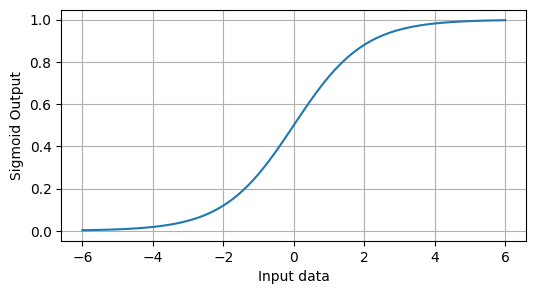

In [47]:
import matplotlib.pyplot as plt # Library for visualization
sigmoid = nn.Sigmoid()
assert not hasattr(sigmoid, "weight") # No learnable weights

data = torch.linspace(start=-6, end=6, steps=100) # One-dimensional vector with 100 elements 
output = sigmoid(data)

fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(data, output)
ax.set_xlabel("Input data")
ax.set_ylabel("Sigmoid Output")

# Add a grid
ax.grid(True)

# Show the plot
plt.show()


Et viktig poeng er at aktiveringsfunksjoner ikke modifiserer _shapen_ til tensoren. Dette kan demonstreres på en tensor med flere shape-dimensjoner. 

In [48]:
data = torch.rand(30, 5, 15)
print(f"shape before activation function: {data.shape}")
data = sigmoid(data)
shape2 = print(f"shape after activation function: {data.shape}")

shape before activation function: torch.Size([30, 5, 15])
shape after activation function: torch.Size([30, 5, 15])


En annen viktig er `nn.Softmax`, og brukes til å transformere en vektor til elementer som summeres til 1. 

Dette gjør den litt annerledes enn Sigmoid, siden vi må spesifisere en av shape-dimensjonene som skal summeres til 1.

Passer fint som siste lag i et nettverk man ønsker skal modellere en sannsynlighetsfordeling (Total sannsynlighet av alle utfallene av en stokastisk variabel skal være 1). Derfor er den veldig relevant for NLP, siden de fleste språkmodeller lærer seg en betinget sannsynlighetsfordeling over ord gitt tidligere tekst. 

For denne anledningen tar vi også i bruk `nn.functional`, som er et delbibliotek som tilbyr mange av komponentene tilstandsfrie. 

In [49]:
import torch.nn.functional as F

# data = torch.Tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
data = torch.randn(3, 3)
print(f"Original data:\n{data}")
data = F.softmax(data, dim=1)
print(f"Transformed data:\n{data}")
print(f"Summing individual batch elements:\n{data.sum(dim=1)}")

Original data:
tensor([[ 0.5718,  0.7593, -0.7781],
        [ 0.0160,  0.0509,  0.3787],
        [ 0.3920, -0.3386,  0.1406]])
Transformed data:
tensor([[0.4056, 0.4893, 0.1052],
        [0.2880, 0.2982, 0.4139],
        [0.4426, 0.2132, 0.3442]])
Summing individual batch elements:
tensor([1.0000, 1.0000, 1.0000])


## Klassifisering av sifre
Vi skal sette opp et nevralt nettverk som er i stand til å klassifisere sifre. Til det trenger vi det lett tilgjengelige MNIST-datasettet. Dette lastes ned gjennom torchvision-biblioteket. Torchvision-biblioteket er et hjelpebibliotek som tilbyr verktøy for Computer Vision-oppgaver. 

Datasett kommer vanligvis i et rå-format, og må behandles for å tilpasse det oppgaven vi skal gjøre. I dette tilfellet får vi PNG-bilder som må gjøres om til tensorer. Vi normaliserer også bildene for å få [bedre resultater](https://developers.google.com/machine-learning/data-prep/transform/normalization). Behandlingen gjøres med `torchvision.transforms`-biblioteket. 

In [50]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

# Pipeline of processing operations
image_processing = transforms.Compose([
    transforms.ToTensor(), # Cast into tensor
    transforms.Normalize((0.5,), (0.5,)) # Pixel-values will range in [-1, 1]
    ])

train_dataset = MNIST(root='./data', train=True, transform=image_processing, download=True)
test_dataset = MNIST(root='./data', train=False, transform=image_processing, download=True) # Test data for later

I maskinlæring trener man flere epoker (iterasjoner) på samme datasettet. 

Hver epoke inneholder flere iterasjoner som består av å oppdatere vektene på et lite subset av datasettet. Man kaller dette for en batch. Denne logikken oppnår vi delvis gjennom `torch.utils.data.DataLoader`. Resten kommer når selve treningen skjer. 

In [51]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32) # Iterable that provides 16 data samples each iteration

data, labels = next(iter(train_loader)) # Retrieve a batch of data samples and labels for inspection purposes
print(f"Shape of data batch: {data.shape}")


Shape of data batch: torch.Size([32, 1, 28, 28])


Tensoren inneholder 16 eksemplarer, 1 fargekanal (grayscale), 28 piksler i høyden, og 28 piksler i bredden.
Vi kan visualisere et tilfeldig eksemplar.

Shown below is the digit 4


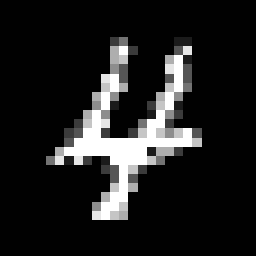

In [52]:
import random
rand_index = random.randint(0, len(data)-1)
data_sample = data[rand_index]
label_sample = labels[rand_index]
image = transforms.functional.resize(data_sample, (256, 256), interpolation=transforms.InterpolationMode.NEAREST) # Upscaling for visual purposes
image = transforms.functional.to_pil_image(image)
print(f"Shown below is the digit {label_sample}")
image

### Vi trenger et nettverk
Alle lag i PyTorch arver fra `nn.Module`. Fra [dokumentasjonen](https://pytorch.org/docs/stable/generated/torch.nn.Module.html):

>Base class for all neural network modules. 
>
>Your models should also subclass this class.
>
>Modules can also contain other Modules, allowing to nest them in a tree structure. You can assign the submodules as regular attributes:

Trestrukturen som snakkes om er veldig nyttig. Endringer vi gjør på toppen av treet vil propageres ned til enkeltmodulene. Feks det å flytte parametrene over på en annen device.

Vi husker det enkle lineære laget og sigmoid-funksjonen. De arver fra `nn.Module`.

In [53]:
print(layer.__class__.__base__)
print(sigmoid.__class__.__base__)

<class 'torch.nn.modules.module.Module'>
<class 'torch.nn.modules.module.Module'>


In [54]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=28*28, out_features=200)
        self.layer2 = nn.Linear(in_features=200, out_features=42)
        self.layer3 = nn.Linear(in_features=42, out_features=10) # 10 digits to differentiate between

        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1) # Softmax will be computed for each batch element separately 

    def logits(self, data):
        flattened_data = torch.flatten(data, start_dim=1, end_dim=-1) # Flatten the tensor from shape (batch_size, 1, 28, 28) to shape (batch_size, 1 * 28 * 28)

        out = self.layer1(flattened_data)
        out = self.sigmoid(out)

        out = self.layer2(out)
        out = self.sigmoid(out)

        out = self.layer3(out)
        return out
    
    def forward(self, data):
        logits = self.logits(data)
        return self.softmax(logits)
    
model = Model() # Initialize model
model.to(device)

Model(
  (layer1): Linear(in_features=784, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=42, bias=True)
  (layer3): Linear(in_features=42, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

Modellen vår implementerer to metoder. `logits` gir unnormaliserte verdier og vil brukes under trening. `forward` bruker `softmax` til å normalisere output fra `logits`, og tas i bruk under _inference_.

Vi tester modellen på sifret vi visualiserte tidligere. 

In [55]:
print(data_sample.shape)
test_input = data_sample[None, ...] # [None, ...] adds a new shape dimension in the front
print(test_input.shape)
test_input = test_input.to(device)

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])


`data_sample[None, ...]` lager en kopi av `data_sample` med en ny dimensjon lagt til.
De fleste modulene i PyTorch forventer at input skal ha en batch-dimensjon, selv om batchen inneholder bare en instans (et bilde i dette tilfellet).

Kodesnutten er veldig kryptisk. 
- PyTorch tolker indeksering med typen `None` som at en ny shape-dimensjon skal lages. 
- De etterfølgende `...` samler de resterende shape-dimensjonene. Dette er det samme som `data_sample[None, :, :, :]`.
- `test_input` består av de nøyaktige samme elementene, men _organisert_ på en annen måte. 


In [56]:
out = model.forward(test_input)
print(out)
print(f"The untrained model predicts the digit to be {out.argmax()}")

tensor([[0.0882, 0.0905, 0.0876, 0.1018, 0.1954, 0.1057, 0.0730, 0.0873, 0.0831,
         0.0874]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
The untrained model predicts the digit to be 4


### Trening
Vi ser fra resultatene at modellen ikke er i stand til å avgjøre hvilket siffer inputten var. 

Vi har modellen og datasettet. Da er det to viktige ting som mangler for å kunne oppnå en fungerende modell. 
- **En loss-funksjon som definerer objectivet**
    - Vi ønsker at modellen skal gi høyest sannsynlighet på det rette sifret.
    
- **En algoritme som utfører gradient descent, altså selve maskinlæringen**
    - Denne algoritmen skal ta utgangspunkt i losset for å optimere parametrene.
    - Man implementerer slike aldri selv, og finner dem heller gjennom `torch.optim`.

Før vi går videre studerer vi disse komponentene hver for seg.

#### Loss-funksjoner
Loss-funksjoner sammenlikner en prediction og et target. Prediction er output fra modellen, og target er fasiten vi vet fra datasettet. 
Den enkleste er _Mean Squared Error (MSE)_, som kalkulerer gjennomsnittlig kvadrert avvik mellom tilsvarende elementer i hver tensor.


In [57]:
a = torch.ones(size=(3, 4, 5))
b = torch.zeros(size=(3, 4, 5))
loss = F.mse_loss(a, b)
print(loss)

a = torch.rand(size=(3, 4, 5))
b = torch.rand(size=(3, 4, 5))
loss = F.mse_loss(a, b)
print(loss)

tensor(1.)
tensor(0.1978)


#### Gradient descent
Helt fram til beregningen av et loss konstrueres det en såkalt _computational graph_. Denne kan propageres bakover for å beregne gradienter (derav det kjente navnet [backpropagation](https://simple.wikipedia.org/wiki/Backpropagation) som brukes i alle nevrale nettverk idag).
- Fra matematikken vet vi at gradienter peker i retning hvor verdien øker mest i en flervariabel kurve. Beveger vi oss i motsatt retning vil verdien minske.
- Learning rate (en skalar verdi) styrer hvor store stegene er. 

Figuren under viser loss-funksjonen kalkulert for forskjellige verdier av parametrene $\theta_1$ og $\theta_2$ til en modell. 

[<img src="https://zitaoshen.rbind.io/project/optimization/1-min-of-machine-learning-gradient-decent/featured_hubf6ae7b9a0510d717632b017746fdfc1_374655_720x0_resize_lanczos_2.png">](https://zitaoshen.rbind.io/project/optimization/1-min-of-machine-learning-gradient-decent/)

<!-- Oppdatering av vektene gjøres da slikt:

$\boldsymbol{w} \leftarrow \underbrace{\alpha}_{\text{learning rate}}$ -->

Selv om konkrete regler finnes for beregning av gradientene til vektene, er det svært kronglete å gjøre manuelt. Derfor takker vi AI-gudene for bibliotek som PyTorch og Tensorflow som gjør denne prosessen så og si automatisk. 

#### Tilbake til treningen av en siffer-gjenkjenneren
Til loss-funksjonen bruker vi `nn.CrossEntropyLoss`. Den sammenlikner to sannsynlighetsfordelinger. Matematikken bak er ikke så viktig.
Til gradient descent bruker vi bruker Adam, som står for _Adaptive Moment Estimation_. Her er heller ikke matematikken viktig. 

In [58]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [59]:
from tqdm import tqdm # Progress bar

model.to(device)

num_epochs = 3

for epoch in range(num_epochs):
    with tqdm(train_loader, unit="batch") as pbar:
        pbar.set_description(f"Epoch {epoch}")
        for i, (data, labels) in enumerate(pbar):
            data = data.to(device)
            labels = labels.to(device)
            pred = model.logits(data) # Query model for predictions
            loss = loss_fn(pred, labels)
            
            loss.backward() # Propagate the computational graph and create gradients
            optimizer.step() # Uses the calculated gradients on the registered parameters to perform an update
            optimizer.zero_grad()

            # pbar.set_postfix(loss=loss.cpu().item()) if i%40 == 0 else None
    

Epoch 4: 100%|██████████| 1875/1875 [00:07<00:00, 250.49batch/s]


### Testing av modellen

In [62]:
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=16)

correct = 0
for data, labels in test_loader:
    data = data.to(device)
    labels = labels.to(device)

    pred = model.forward(data)
    correct += torch.sum(pred.argmax(dim=1) == labels)
accuracy = correct/len(test_dataset)

print(f"The accuracy of the model on the test set is {accuracy}")

The accuracy of the model on the test set is 0.9700999855995178


tensor([[1.2183e-05, 4.5660e-06, 2.0896e-05, 1.0790e-06, 9.9911e-01, 1.1115e-05,
         4.6724e-05, 2.4501e-04, 4.6683e-05, 5.0670e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
The trained model predicts the digit to be 4


<BarContainer object of 10 artists>

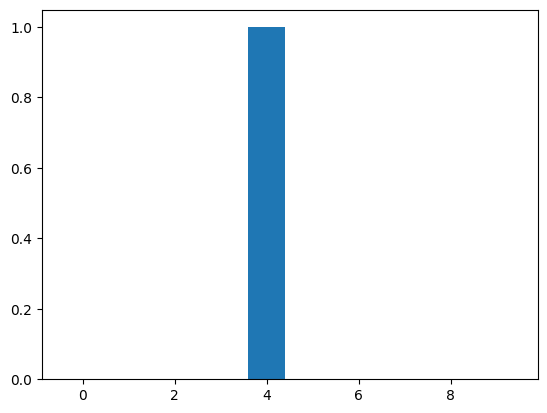

In [73]:
out = model.forward(test_input)
print(out)
print(f"The trained model predicts the digit to be {out.argmax()}")
plt.bar(torch.linspace(0, 9, 10).numpy(), out[0].cpu().detach())

## Inspo før vi går til NLP
I NLP er embeddings viktig

Autoencoder

## Trening foregår i Python (kjent som det trege spåket), hvor 

## Oppvarming til NLP